In [1]:
# 기본 사용 library import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 분류모델 기본 library import
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
# base model import
import xgboost as xgb

# model과 사용되는 library import
from tqdm import tqdm
import joblib

In [2]:
## working directory 설정
new_working_directory = "/Users/hyunbin/Library/CloudStorage/OneDrive-Personal/05 빅데이터 전문가 과정/01 통계 데이터 사이언스/00 팀플/final/new"
os.chdir(new_working_directory)

# 확인
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/hyunbin/Library/CloudStorage/OneDrive-Personal/05 빅데이터 전문가 과정/01 통계 데이터 사이언스/00 팀플/final/new


# 가. 데이터 불러오기

In [3]:
test_raw = pd.read_csv("./00 data/test_trd_timeline.csv")
tbill = pd.read_csv("./00 data/tbill_15_mod.csv")

In [4]:
## 원본데이터 보호
test_data = test_raw.copy()

In [5]:
# 칼럼명 변경 : model에 input할 때 오류가 발생하기에 이와 같이 처리
test_data = test_data.rename(columns={'verification_status_Source Verified': 'verification_status_Source_Verified'})

# 나. 수익률 계산하기

In [6]:
## 날짜 데이터 타입을 datetime으로 통일 (매우 중요)
test_data['issue_d'] = pd.to_datetime(test_data['issue_d'], errors='coerce')
tbill['observation_date'] = pd.to_datetime(tbill['observation_date'], errors='coerce')


## test_data와 tbill을 'issue_d'와 'observation_date'를 기준으로 병합
test_data = pd.merge(test_data, tbill,
                       left_on='issue_d', right_on='observation_date',
                       how='left')

## data frame 정비
test_data = test_data.rename(columns={'DTB3': 'rf_rate'})  # 'DTB3' 컬럼 이름을 'rf_rate'로 변경
test_data = test_data.drop(columns=['issue_d', 'observation_date'], errors='ignore')  # 'issue_d'와 'observation_date' 열 삭제


/var/folders/yb/vl5rylzx0dv4gxwytw3c2h080000gn/T/ipykernel_4949/225759129.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['issue_d'] = pd.to_datetime(test_data['issue_d'], errors='coerce')
/var/folders/yb/vl5rylzx0dv4gxwytw3c2h080000gn/T/ipykernel_4949/225759129.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tbill['observation_date'] = pd.to_datetime(tbill['observation_date'], errors='coerce')


In [7]:
## 수익률 산출
test_data['earning_rate'] = test_data['int_rate']-test_data['rf_rate']
test_data = test_data.drop(columns=['rf_rate'], errors='ignore')

## 소수 셋째자리에서 반올림
test_data['earning_rate'] = test_data['earning_rate'].round(3)

# 다. 예측 실행

In [8]:
save_path = "./02 model/best_default_model.pkl"

## threshold 가지고 오기
loaded_data = joblib.load(save_path)
loaded_model = loaded_data['model']

# 'threshold' 키를 사용하여 임계값을 가져옴
best_threshold = loaded_data['threshold']

print(f"Using the model's stored threshold: {best_threshold:.4f}")


## Best iteration 확인
if loaded_model is not None:
    if hasattr(loaded_model, 'best_iteration'):
        best_iteration = loaded_model.best_iteration
        print(f"Using best iteration: {best_iteration}")
    else:
        best_iteration = None
        print("No best_iteration found in the saved model.")


Using the model's stored threshold: 0.5100
No best_iteration found in the saved model.


In [9]:
# 예측 데이터와 훈련 데이터의 피처 수 맞추기 (Corrected for XGBoost)
def check_and_prepare_features(df, model):
    """
    DataFrame과 학습된 모델(XGBoost) 간의 누락된 기능을 확인하는 함수
    기본값(0)으로 누락된 기능을 추가하고 올바른 열 순서 보장

    Args:
        df: 예측에 사용할 pd.dataframe
        model: trained XGBoost 모델.

    Returns:
        올바른 순서와 피쳐를 가진 pd.dataframe 준비
	    에러 있으면 None return
    """
    try:
        if hasattr(model, 'feature_names'):
            trained_features = model.feature_names
        elif hasattr(model, 'feature_name'):
            trained_features = model.feature_name()
        elif hasattr(model, 'get_fscore'):
            trained_features = list(model.get_fscore().keys())
        else:
            raise AttributeError("Could not determine feature names from the XGBoost model.")

        current_features = df.columns.tolist()

        # 초과된 피처 확인 및 제거
        extra_features = [col for col in current_features if col not in trained_features]
        if extra_features:
            print("Extra features (removed):", extra_features)
            df = df.drop(columns=extra_features)

        # 피처 순서 맞추기
        df = df[trained_features]
        return df

    except AttributeError as e:
        print(f"Error: {e}")
        print("Make sure 'model' is a valid XGBoost model and has been trained.")
        return None


In [10]:
## 예측 진행
# 예측을 진행하기 위한 준비
df_out = check_and_prepare_features(test_data.copy(), loaded_model)

if df_out is not None:
    dtest = xgb.DMatrix(df_out)

    if best_iteration is not None:
        predictions_prob = loaded_model.predict(dtest, iteration_range=(0, best_iteration))
    else:
        predictions_prob = loaded_model.predict(dtest)
        
    predictions = (predictions_prob >= best_threshold).astype(int)

    # 칼럼 저장
    test_data['def_prob_pred'] = predictions_prob
    test_data['def_pred'] = (predictions_prob >= best_threshold).astype(int)

Extra features (removed): ['grade', 'loan_status', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'last_fico_range_low', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source_Verified', 'verification_status_Verified', 'earning_rate']


In [11]:
## 결과 확인
# 최적 임계치를 사용하여 최종 예측
y_test = test_data['loan_status']
y_pred_final_lgb = predictions

# classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_final_lgb))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix_final_lgb = confusion_matrix(y_test, y_pred_final_lgb)
print("\nFinal Confusion Matrix (lightGBM):")
print("                 Predicted Negative (0)   Predicted Positive (1)")
print(f"Actual Negative (0)      {conf_matrix_final_lgb[0, 0]} (TN)             {conf_matrix_final_lgb[0, 1]} (FP)")
print(f"Actual Positive (1)      {conf_matrix_final_lgb[1, 0]} (FN)             {conf_matrix_final_lgb[1, 1]} (TP)")

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_final_lgb)))

## 종합 평가지표 계산
accuracy = accuracy_score(y_test, y_pred_final_lgb)
precision = precision_score(y_test, y_pred_final_lgb)
recall = recall_score(y_test, y_pred_final_lgb)
f1 = f1_score(y_test, y_pred_final_lgb)

print("\nOverall Metrics:")
print("Accuracy:  {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    549165
           1       0.75      0.73      0.74    131764

    accuracy                           0.90    680929
   macro avg       0.84      0.84      0.84    680929
weighted avg       0.90      0.90      0.90    680929

Confusion Matrix:

Final Confusion Matrix (lightGBM):
                 Predicted Negative (0)   Predicted Positive (1)
Actual Negative (0)      517647 (TN)             31518 (FP)
Actual Positive (1)      35356 (FN)             96408 (TP)
Test Accuracy: 0.9018

Overall Metrics:
Accuracy:  0.9018
Precision: 0.7536
Recall:    0.7317
F1 Score:  0.7425


# 라. Sharpe Ratio

In [12]:
## bootstrapping 횟수
n_iterations = 1000

In [13]:
## 대출 승인자 추출 : fully paid로 예측된 사람
test_data_ls = test_data[test_data['def_pred'] == 0]

## 전체 통계량
mean_earning_rate = test_data_ls['earning_rate'].mean()
std_earning_rate = test_data_ls['earning_rate'].std()
sharpe_ratio = mean_earning_rate/std_earning_rate

print(f"Mean of earning_rate: {mean_earning_rate:.4f}")  # 소수점 4자리까지 표시
print(f"Standard deviation of earning_rate: {std_earning_rate:.4f}")
print(f"Sharpe Ratio : {sharpe_ratio:.4f}")

Mean of earning_rate: 11.9312
Standard deviation of earning_rate: 4.6214
Sharpe Ratio : 2.5817


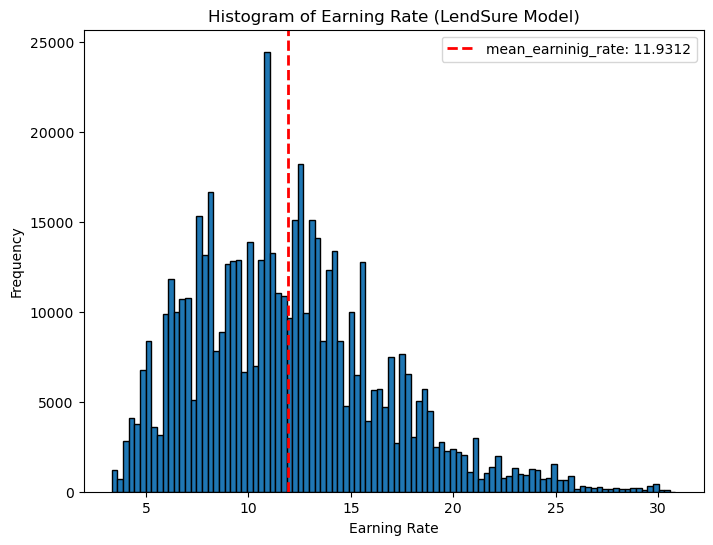

In [14]:
## LS model earning rate histogram
plt.figure(figsize=(8, 6))
plt.hist(test_data_ls['earning_rate'], bins=100, edgecolor='black')

plt.title('Histogram of Earning Rate (LendSure Model)')
plt.xlabel('Earning Rate')
plt.ylabel('Frequency')

plt.axvline(mean_earning_rate, color='red', linestyle='dashed', linewidth=2, label=f'mean_earninig_rate: {mean_earning_rate:.4f}')
plt.legend()

plt.show()

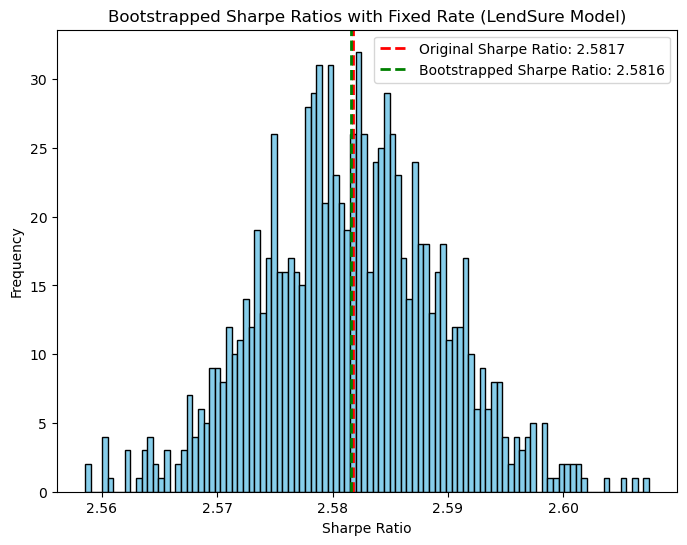


Bootstrapped Sharpe Ratios (Statistics):
  Mean: 2.5816
  Std: 0.0078
  2.5th Percentile: 2.5668
  97.5th Percentile: 2.5971


In [15]:
## Bootstrapping : fixed rate (10%)
bootstrapped_sharpe_ratios = []
sample_number = int(len(test_data_ls)*0.1)

for _ in range(n_iterations):
    sample = test_data_ls['earning_rate'].sample(n=sample_number, replace=True)

    # Sharpe Ratio 계산
    sample_mean = sample.mean()
    sample_std = sample.std()

    # ZeroDivisionError 처리 (표준편차가 0이 되는 경우)
    if sample_std == 0:
        bootstrapped_sharpe_ratios.append(np.nan)
    else:
        sample_sharpe_ratio = sample_mean / sample_std
        bootstrapped_sharpe_ratios.append(sample_sharpe_ratio)

# Bootstrapped Sharpe Ratio 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(bootstrapped_sharpe_ratios, bins=100, edgecolor='black', color='skyblue')
plt.title('Bootstrapped Sharpe Ratios with Fixed Rate (LendSure Model)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')

bootstrap_mean = np.nanmean(bootstrapped_sharpe_ratios)  # 원래 Sharpe Ratio를 빨간색 선으로 표시

plt.axvline(sharpe_ratio, color='red', linestyle='dashed', linewidth=2, label=f'Original Sharpe Ratio: {sharpe_ratio:.4f}')
plt.axvline(bootstrap_mean, color='green', linestyle='dashed', linewidth=2, label=f'Bootstrapped Sharpe Ratio: {np.nanmean(bootstrapped_sharpe_ratios):.4f}')
plt.legend()

plt.show()

# Bootstrapped with Fixed Rate의 Sharpe Ratio 통계량
print(f"\nBootstrapped Sharpe Ratios (Statistics):")
print(f"  Mean: {np.nanmean(bootstrapped_sharpe_ratios):.4f}")
print(f"  Std: {np.nanstd(bootstrapped_sharpe_ratios):.4f}")
print(f"  2.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 2.5):.4f}")
print(f"  97.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 97.5):.4f}")


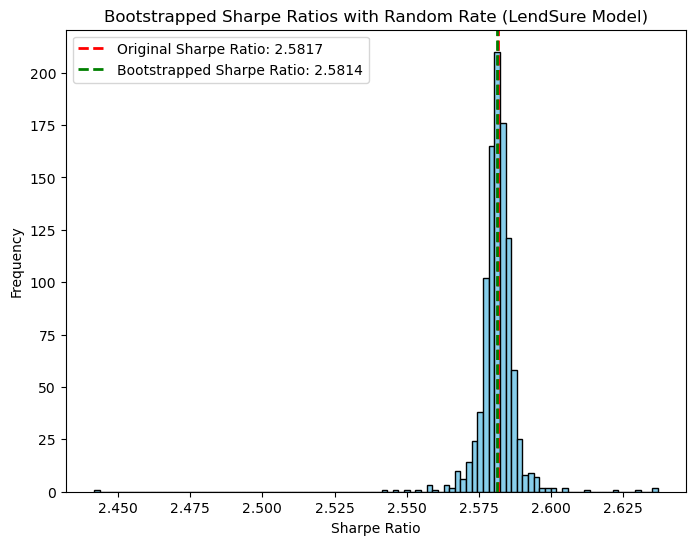


Bootstrapped Sharpe Ratios (Statistics):
  Mean: 2.5814
  Std: 0.0077
  2.5th Percentile: 2.5689
  97.5th Percentile: 2.5933


In [16]:
## Bootstrapping : random rate
bootstrapped_sharpe_ratios = []

for _ in range(n_iterations):
    random_number = np.random.rand()
    sample_number = int(len(test_data_ls)*random_number)

    sample = test_data_ls['earning_rate'].sample(n=sample_number, replace=True)

    # Sharpe Ratio 계산
    sample_mean = sample.mean()
    sample_std = sample.std()

    # ZeroDivisionError 처리 (표준편차가 0이 되는 경우)
    if sample_std == 0:
        bootstrapped_sharpe_ratios.append(np.nan)
    else:
        sample_sharpe_ratio = sample_mean / sample_std
        bootstrapped_sharpe_ratios.append(sample_sharpe_ratio)

# Bootstrapped Sharpe Ratio 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(bootstrapped_sharpe_ratios, bins=100, edgecolor='black', color='skyblue')
plt.title('Bootstrapped Sharpe Ratios with Random Rate (LendSure Model)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')


bootstrap_mean = np.nanmean(bootstrapped_sharpe_ratios) # 원래 Sharpe Ratio를 빨간색 선으로 표시

plt.axvline(sharpe_ratio, color='red', linestyle='dashed', linewidth=2, label=f'Original Sharpe Ratio: {sharpe_ratio:.4f}')
plt.axvline(bootstrap_mean, color='green', linestyle='dashed', linewidth=2, label=f'Bootstrapped Sharpe Ratio: {np.nanmean(bootstrapped_sharpe_ratios):.4f}')
plt.legend()

plt.show()

# Bootstrapped with Random Rate Sharpe Ratio 통계량
print(f"\nBootstrapped Sharpe Ratios (Statistics):")
print(f"  Mean: {np.nanmean(bootstrapped_sharpe_ratios):.4f}")
print(f"  Std: {np.nanstd(bootstrapped_sharpe_ratios):.4f}")
print(f"  2.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 2.5):.4f}")
print(f"  97.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 97.5):.4f}")


# 마. Lending Club model analysis

In [17]:
test_data_lc = test_data.copy()

In [18]:
## 전체 통계량
mean_earning_rate = test_data_lc['earning_rate'].mean()
std_earning_rate = test_data_lc['earning_rate'].std()
sharpe_ratio = mean_earning_rate/std_earning_rate

print(f"Mean of earning_rate: {mean_earning_rate:.4f}")  # 소수점 4자리까지 표시
print(f"Standard deviation of earning_rate: {std_earning_rate:.4f}")
print(f"Sharpe Ratio : {sharpe_ratio:.4f}")

Mean of earning_rate: 12.5822
Standard deviation of earning_rate: 4.8969
Sharpe Ratio : 2.5694


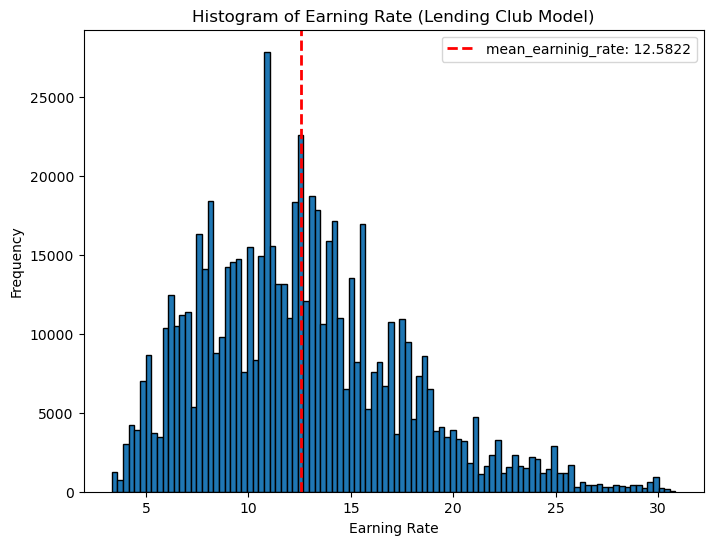

In [19]:
## LC model earning rate histogram
plt.figure(figsize=(8, 6))
plt.hist(test_data_lc['earning_rate'], bins=100, edgecolor='black')

plt.title('Histogram of Earning Rate (Lending Club Model)')
plt.xlabel('Earning Rate')
plt.ylabel('Frequency')

plt.axvline(mean_earning_rate, color='red', linestyle='dashed', linewidth=2, label=f'mean_earninig_rate: {mean_earning_rate:.4f}')
plt.legend()

plt.show()

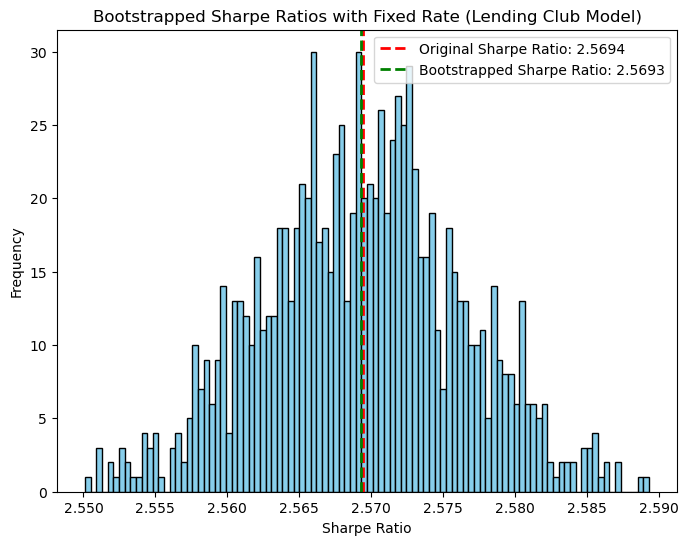


Bootstrapped Sharpe Ratios (Statistics):
  Mean: 2.5693
  Std: 0.0069
  2.5th Percentile: 2.5554
  97.5th Percentile: 2.5823


In [20]:
# Bootstrapping : fixed rate (10%)
bootstrapped_sharpe_ratios = []
sample_number = int(len(test_data_lc)*0.1)

for _ in range(n_iterations):
    sample = test_data_lc['earning_rate'].sample(n=sample_number, replace=True)

    # Sharpe Ratio 계산
    sample_mean = sample.mean()
    sample_std = sample.std()

    # ZeroDivisionError 처리 (표준편차가 0이 되는 경우)
    if sample_std == 0:
        bootstrapped_sharpe_ratios.append(np.nan) 
    else:
        sample_sharpe_ratio = sample_mean / sample_std
        bootstrapped_sharpe_ratios.append(sample_sharpe_ratio)

# Bootstrapped Sharpe Ratio 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(bootstrapped_sharpe_ratios, bins=100, edgecolor='black', color='skyblue')
plt.title('Bootstrapped Sharpe Ratios with Fixed Rate (Lending Club Model)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')

bootstrap_mean = np.nanmean(bootstrapped_sharpe_ratios) # 원래 Sharpe Ratio를 빨간색 선으로 표시

plt.axvline(sharpe_ratio, color='red', linestyle='dashed', linewidth=2, label=f'Original Sharpe Ratio: {sharpe_ratio:.4f}')
plt.axvline(bootstrap_mean, color='green', linestyle='dashed', linewidth=2, label=f'Bootstrapped Sharpe Ratio: {np.nanmean(bootstrapped_sharpe_ratios):.4f}')
plt.legend()

plt.show()

# Bootstrapped Sharpe Ratio 통계량
print(f"\nBootstrapped Sharpe Ratios (Statistics):")
print(f"  Mean: {np.nanmean(bootstrapped_sharpe_ratios):.4f}")
print(f"  Std: {np.nanstd(bootstrapped_sharpe_ratios):.4f}")
print(f"  2.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 2.5):.4f}")
print(f"  97.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 97.5):.4f}")


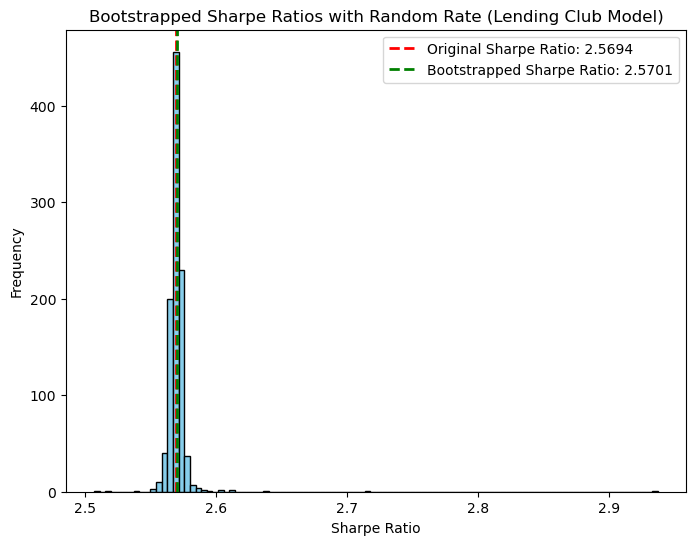


Bootstrapped Sharpe Ratios (Statistics):
  Mean: 2.5701
  Std: 0.0139
  2.5th Percentile: 2.5597
  97.5th Percentile: 2.5790


In [21]:
# Bootstrapping : random rate
bootstrapped_sharpe_ratios = []

for _ in range(n_iterations):
    random_number = np.random.rand()
    sample_number = int(len(test_data_lc)*random_number)

    sample = test_data_lc['earning_rate'].sample(n=sample_number, replace=True)

    # Sharpe Ratio 계산
    sample_mean = sample.mean()
    sample_std = sample.std()

    # ZeroDivisionError 처리 (표준편차가 0이 되는 경우)
    if sample_std == 0:
        bootstrapped_sharpe_ratios.append(np.nan)
    else:
        sample_sharpe_ratio = sample_mean / sample_std
        bootstrapped_sharpe_ratios.append(sample_sharpe_ratio)

# Bootstrapped Sharpe Ratio 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(bootstrapped_sharpe_ratios, bins=100, edgecolor='black', color='skyblue')
plt.title('Bootstrapped Sharpe Ratios with Random Rate (Lending Club Model)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')

bootstrap_mean = np.nanmean(bootstrapped_sharpe_ratios)  # 원래 Sharpe Ratio를 빨간색 선으로 표시

plt.axvline(sharpe_ratio, color='red', linestyle='dashed', linewidth=2, label=f'Original Sharpe Ratio: {sharpe_ratio:.4f}')
plt.axvline(bootstrap_mean, color='green', linestyle='dashed', linewidth=2, label=f'Bootstrapped Sharpe Ratio: {np.nanmean(bootstrapped_sharpe_ratios):.4f}')
plt.legend()

plt.show()

# Bootstrapped Sharpe Ratio 통계량
print(f"\nBootstrapped Sharpe Ratios (Statistics):")
print(f"  Mean: {np.nanmean(bootstrapped_sharpe_ratios):.4f}")
print(f"  Std: {np.nanstd(bootstrapped_sharpe_ratios):.4f}")
print(f"  2.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 2.5):.4f}")
print(f"  97.5th Percentile: {np.nanpercentile(bootstrapped_sharpe_ratios, 97.5):.4f}")
